In [12]:
from collections import Counter, namedtuple, defaultdict
from pprint import pprint
from itertools import groupby, permutations, filterfalse
from copy import deepcopy
import re

import matplotlib.pyplot as plt
from Bio import SeqIO
import editdistance
import networkx as nx
import graph_tool.all as gt

from vdj_walker import *

%matplotlib inline

In [3]:
"""Define constants"""
KMER_LEN = 7
PAIR_TRESHOLD = 15
COOL_TRESHOLD = 25
IMP_TRESHOLD = 10

"""Define data types"""
D = namedtuple('D', ['gene', 'J_gene', 'V_gene'])
Comb = namedtuple('Comb', ['gene', 'pos'])
DGene = namedtuple('DGene', ['read', 'gene'])
Kmer = namedtuple('Kmer', ['seq', 'j', 'v', 'dataset'])


#################################################### READING
def get_fa_header_value(line, *, index):
    return line.split('|')[index].split(':')[1]

def read_fa(file):
    for record in SeqIO.parse(file, 'fasta'):
        yield str(record.seq)

def read_J(file):
    for record in SeqIO.parse(file, 'fasta'):
        id_ = get_fa_header_value(record.id, index=1)
        if id_.startswith('cluster'):
           seq_len = len(str(record.seq).replace('-', ''))
        else:
            yield Comb(id_, seq_len)

def read_genes(file):
    for record in SeqIO.parse(file, 'fasta'):
        gene = record.id
        read = str(record.seq).upper()
        yield DGene(read, gene)

def read_V_headers(file):
    length = 0
    for record in SeqIO.parse(file, 'fasta'):
        if 'READ' in record.id:
            length = int(get_fa_header_value(record.id, index=3))
        elif 'GENE' in record.id:
            gene = get_fa_header_value(record.id, index=1)
            yield Comb(gene, length)

def split_kmers(read, size):
    for i in range(len(read) - size + 1):
        kmer = read[i : i + size]
        yield kmer

def read_info(csv):
    for line in csv:
        atrs = line.split()
        v = Comb(atrs[4], int(atrs[2]) - 1)
        j = Comb(atrs[8], int(atrs[5]) - 1)
        yield (v, j)

def fetch_d(vdj_dir: Path, i):
    clean_reads = read_fa(open(vdj_dir / 'cleaned_reads.fasta', 'r'))
    info = read_info(open(vdj_dir / 'alignment_info.csv'))
    
    for read, (v, j) in zip(clean_reads, info):
        d_read = read[v.pos + 1 : j.pos]
        yield (d_read, (j.gene, v.gene, i))

def read_iter():
    for i, vdj_dir in enumerate(vdj_dir_iter()):
        for read, info in fetch_d(vdj_dir, i):
            yield (read, info)

            
#################################################### KMER CLEANING
def read_imp(read):
    for kmer in split_kmers(read, KMER_LEN):
        if kmer not in ds_kmers:
            if kmer in good:
                yield kmer_pairs[kmer]
            else:
                yield 0
        else:
            yield kmer_pairs[kmer]

def is_good(n):
    return n >= IMP_TRESHOLD


#################################################### READ
def split_read(read):
    global bad_counter, distribution, max_seq_counter
    
    read_map = list(enumerate(map(is_good, read_imp(read))))
    
    for i, imp_id in read_map:
        distribution[i][int(imp_id)] += 1
        
    bad_counter += len(list(filter(lambda x: not x[1], read_map)))
    
    gb = groupby(read_map, lambda x: x[1])
    gb = list(map(lambda x: (x[0], list(x[1])), gb))
    max_good_seq = 0
    for ids in filter(lambda x: x[0], gb):
        ids = list(map(lambda x: x[0], ids[1]))
        max_good_seq = max(max_good_seq, len(ids))
        yield read[ids[0]:(ids[-1] + KMER_LEN)]
    if max_good_seq > 0:
        max_seq_counter[max_good_seq] += 1


def merge_pairs():
    """Merge pairs"""
    global cleaned_reads
    deleted = set()
    for seg1, seg2 in permutations(cleaned_reads.keys(), 2):
        if any(seg in deleted for seg in (seg1, seg2)):
            continue
        if seg2 in seg1:
            cleaned_reads[seg1] += cleaned_reads[seg2]
            del cleaned_reads[seg2]
            deleted.add(seg2)
    return

def clean_vj():
    bad_infos = set()
    for read, infos in cleaned_reads.items():
        bad = set()
        for info, n in infos.items():
            if n < 15:
                bad.add(info)
        for info in bad:
            infos.pop(info)
        if len(infos) == 0:
            bad_infos.add(read)
    for read in bad_infos:
        cleaned_reads.pop(read)

def is_cool(read):
    return any(kmer in read for kmer in cool)

In [4]:
#################################################### KMER OPS
"""Kmers in known D segments"""
Ds = list(read_genes(open(gene_dir / 'IGHD-allP.fa', 'r')))
l = 0
n = 0
ds_kmers = set()
for i in Ds:
    l += len(i.read)
    n += 1
    for kmer in split_kmers(i.read, KMER_LEN):
        ds_kmers.add(kmer)
print(l / n)

24.318181818181817


In [5]:
#################################################### READ OPS
"""Cut D segments from all datasets"""
raw_kmers = Counter()
for read, info in read_iter():
    for seq in split_kmers(read, KMER_LEN):
        raw_kmers[Kmer(seq, *info)] += 1
print('Raw kmers:', len(raw_kmers))

"""Count kmer pairs and delete kmers with less than PAIR_TRESHOLD number of occurences"""
kmer_pairs = Counter()
for kmer, n in raw_kmers.items():
    if n > PAIR_TRESHOLD:
        kmer_pairs[kmer.seq] += 1
print('Paired kmers:', len(kmer_pairs))

"""Filter kmers with small number of pairs"""
good = set()
for kmer, n in kmer_pairs.items():
    if n >= 20:
        good.add(kmer)
print('Good kmers:', len(good))

"""Filter kmers with small number of pairs"""
cool = set()
for kmer, n in kmer_pairs.items():
    if kmer not in ds_kmers and n >= COOL_TRESHOLD:
        cool.add(kmer)
print('Cool kmers:', len(cool))

Raw kmers: 3039905
Paired kmers: 8350
Good kmers: 211
Cool kmers: 14


In [6]:
"""Clean trash from d segments"""
bad_counter = 0
cleaned_reads = defaultdict(Counter)
before_len = Counter()
after_len = Counter()
distribution = [[0, 0] for _ in range(200)]
max_seq_counter = Counter()

for read, info in read_iter():
    before_len[len(read)] += 1
    for clean_read in split_read(read):
        after_len[len(clean_read)] += 1
        cleaned_reads[clean_read][info] += 1

print(len(cleaned_reads))
print(bad_counter)

7452
5098386


In [7]:
merge_pairs()
print('Merged clean reads:', len(cleaned_reads))

Merged clean reads: 767


In [8]:
def Na():
    sa = 0
    for infos in cleaned_reads.values():
        sa += len(infos)
    return sa / len(cleaned_reads)

print(Na())
clean_vj()
print(Na())

162.94915254237287
17.414364640883978


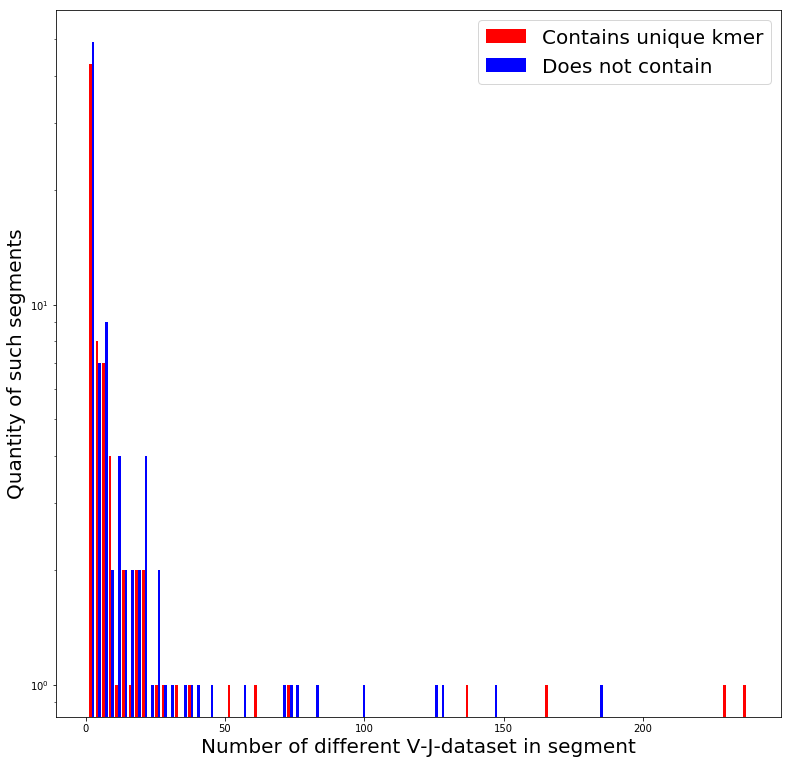

In [9]:
cleaned_plot = plt.figure(figsize=(13, 13))

def xs(cont):
    for read, infos in cleaned_reads.items():
        #if len(infos) > 1000: continue
        if is_cool(read) == cont:
            yield len(infos)

_ = plt.hist([list(xs(True)), list(xs(False))], bins=100, 
             color=['r', 'b'], log=True, label=['Contains unique kmer', 'Does not contain'])
plt.xlabel('Number of different V-J-dataset in segment', fontsize=20)
plt.ylabel('Quantity of such segments', fontsize=20)
plt.legend(fontsize=20)

In [63]:
cleaned_plot.savefig('cleaned3.png')

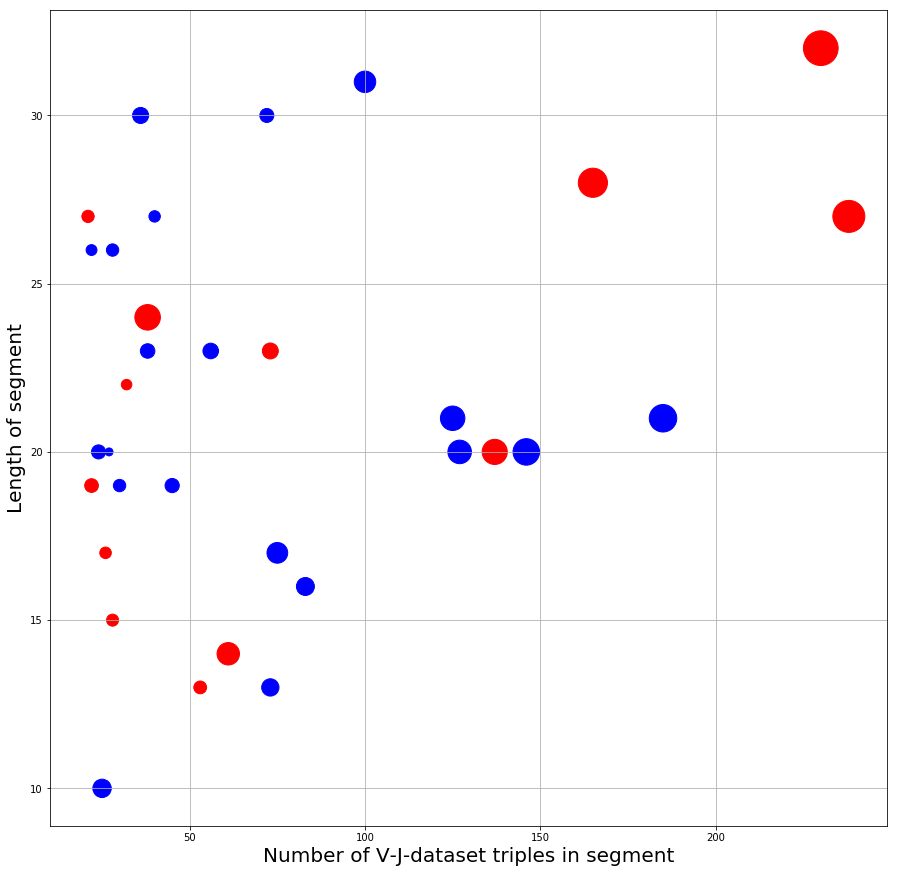

In [207]:
from random import random
dot_plot = plt.figure(figsize=(15, 15))
x = []
y = []
c = []
s = []
for read, infos in mega.items():
    x.append(len(infos))
    y.append(len(read))
    c.append(int(is_cool(read)) and 'r' or 'b')
    s.append(sum(infos.values()) / 10)

plt.scatter(x, y, c=c, s=s)
plt.grid()
plt.xlabel('Number of V-J-dataset triples in segment', fontsize=20)
plt.ylabel('Length of segment', fontsize=20)

In [154]:
mega = {read: infos for read, infos in cleaned_reads.items() if len(infos) > 20}
len(mega)

33

In [97]:
dot_plot.savefig('dots.png')

In [11]:
def find_best_dist(read, other):
    return min((editdistance.eval(read, read2), read2) for read2 in other)

def get_edges(peaks):
    for read in peaks:
        best_n = find_best_dist(read, peaks - {read,})
        best_f = find_best_dist(read, cleaned_reads.keys() - peaks)
        yield (read, best_n, best_f)

32


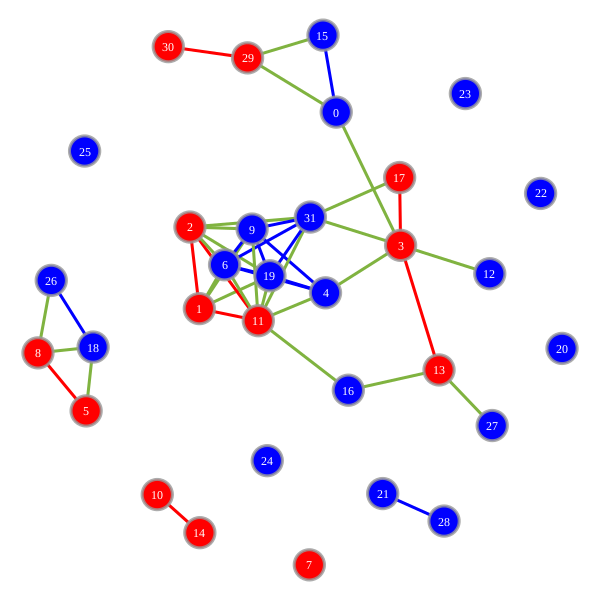

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f77aaf70f28, at 0x7f77aaf73160>

In [227]:
BLUE = [0., 0., 1., 1.]
RED = [1., 0., 0., 1.]
GREEN = [0.5, 0.7, 0.25, 1.]

G = gt.Graph()
G.set_directed(False)

name = G.new_vertex_property('string')
color = G.new_vertex_property('vector<float>')
cool_v = G.new_vertex_property('bool')

for peak in mega.keys():
    v = G.add_vertex()
    
    name[v] = peak
    cool_v[v] = is_cool(peak)
    color[v] = cool_v[v] and RED or BLUE

weight = G.new_edge_property('double')
ecolor = G.new_edge_property('vector<float>')


def find_best_dist(v1, with_cool):
    dist_map = []
    for v2 in G.vertices():
        if v1 != v2 and cool_v[v2] == with_cool:
            dist = editdistance.eval(name[v1], name[v2])
            dist_map.append((dist, v2))
    return filter(lambda x: x[0] < 9, dist_map)

def get_edges(cools):
    for readv in G.vertices():
        if cool_v[readv] != cools: continue
        best_n = find_best_dist(readv, with_cool=cools)
        best_f = find_best_dist(readv, with_cool=not cools)
        yield (readv, best_n, best_f) 
        
def add_edge_(v1, v2, n, cl):
    global G, weight, color
    e = G.add_edge(v1, v2)
    #print(e)
    weight[e] = 1 / n
    ecolor[e] = cl

def cluster(cools, gcl, bcl):
    for read, best_n, best_f in get_edges(cools):
        all_n = set(read.all_neighbours())
        for n, n_read in best_n:
            if not (n_read in all_n):
                add_edge_(read, n_read, n, gcl)
        for f, f_read in best_f:
            if not(f_read in all_n):
                add_edge_(read, f_read, f, bcl)

cluster(True, RED, GREEN)
cluster(False, BLUE, GREEN)
#print(len(name))

print(G.num_vertices())
pos = gt.sfdp_layout(G, eweight=weight, p=2)
#pos2 = gt.fruchterman_reingold_layout(G, weight=weight, circular=True)
#pos3 = gt.arf_layout(G, weight=weight)
gt.graph_draw(G, 
              pos=pos,
              vertex_text=G.vertex_index, 
              #vertex_color=color,
              output_size=(600, 600),
              vertex_fill_color=color,
              fmt='png',
              output='test.png',
              inline=True,
              edge_color=ecolor,
              )

In [225]:
print(name[G.vertex(10)])
print(name[G.vertex(14)])
print(name[G.vertex(28)])
print(name[G.vertex(7)])

CGTATTACGATTTTTGGAGTGGTTACC
CGTATTACGATTTTTGGAGTGGTTATTC
GTGGATATTGTAGTAGTACCAGCTGCC
CGTATTACTATGATAGTAGTGGTTATTACTAC


In [202]:
editdistance.eval('AAA', 'A')

2

HEEELOOOO


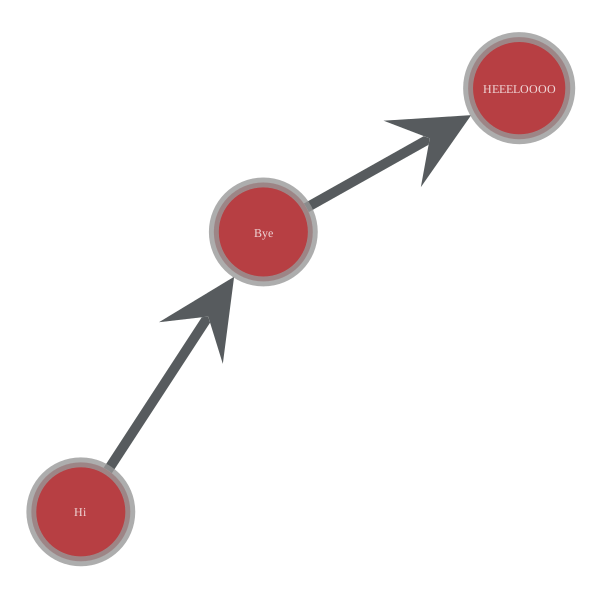

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f77ab462e48, at 0x7f77ab1e9668>

In [36]:
g = gt.Graph()

name = g.new_vertex_property('string')
v1 = g.add_vertex()
name[v1] = 'Hi'
v2 = g.add_vertex()
name[v2] = 'Bye'
v3 = g.add_vertex()
name[v3] = 'HEEELOOOO'
print(name[v3])

weight = g.new_edge_property('double')
weight[g.add_edge(v1, v2)] = 50.5
weight[g.add_edge(v2, v3)] = 200.1

pos = gt.sfdp_layout(g, eweight=weight, p=10.0)
gt.graph_draw(g, pos=pos, vertex_text=name, inline=True)

In [48]:
A = nx.nx_agraph.to_agraph(G)
A.write('vdj_graph.dot')

In [68]:
comb_reads = defaultdict(list)
for read, triples in cleaned_reads.items():
    if len(set(map(lambda x: x[2], triples))) < 2:
        continue
        
    comb = tuple(kmer for kmer in cool if kmer in read)
    #print(comb)
    if len(comb) > 1:
        comb_reads[comb].append(read)

len(comb_reads)

13

In [49]:
t = nx.DiGraph()
t.add_edge(1, 2, len=100)
t.add_edge(2, 3, len=10)
at = nx.nx_agraph.to_agraph(t)
at.write('test_vdj.dot')

In [22]:
help(gt.draw)

Help on package graph_tool.draw in graph_tool:

NAME
    graph_tool.draw

DESCRIPTION
    ``graph_tool.draw`` - Graph drawing and layout
    ----------------------------------------------
    
    Summary
    +++++++
    
    Layout algorithms
    
    .. autosummary::
       :nosignatures:
    
       sfdp_layout
       fruchterman_reingold_layout
       arf_layout
       radial_tree_layout
       planar_layout
       random_layout
       get_hierarchy_control_points
    
    Graph drawing
    
    .. autosummary::
       :nosignatures:
    
       graph_draw
       draw_hierarchy
       graphviz_draw
       prop_to_size
    
    
    Low-level graph drawing
    ^^^^^^^^^^^^^^^^^^^^^^^
    
    .. autosummary::
       :nosignatures:
    
       cairo_draw
       interactive_window
       GraphWidget
       GraphWindow
    
    Contents
    ++++++++

PACKAGE CONTENTS
    cairo_draw
    graphviz_draw
    gtk_draw
    libgraph_tool_draw
    libgraph_tool_layout

FUNCTIONS
    arf_layout(

In [34]:
import graph_tool.draw as gt

In [35]:
gt.graph_drawtt

<function graph_tool.draw.graphviz_draw.graphviz_draw>

In [208]:
n = 0
for i in read_iter():
    n += 1
n

370485